<a href="https://colab.research.google.com/github/daferocu/Topicos-Avanzados/blob/main/datalab/Proyecto%202/P1_MovieGenrePrediction_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Genre Classification**

**Proyecto Procesamiento de Lenguaje Natural - NLP**

**Profesor:** Sergio Alberto Mora Pardo

**Integrantes:**

*   Daniel Rodríguez
*   Diana Ibáñez
*   Oscar Correcha
*   Erika Cárdenas
*   Paola Castro


**Objetivo:**
Clasificar el género de la película según su trama.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### Data

*Input:*
- movie plot

*Output:*
Probability of the movie belong to each genre


### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

In [1]:
# Instalar librerías requeridas
import os
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# **1. Adquisición de los datos**

In [2]:
# Leer archivos .csv con el dataset para entrenamiento y prueba
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

dataTraining.head()


,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [3]:
# Explorar las dimensiones del dataset de entrenamiento
dataTraining.shape

(7895, 5)

In [4]:
# Descripción de los datos en el dataset de entrenamiento
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7895 entries, 3107 to 215
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    7895 non-null   int64  
 1   title   7895 non-null   object 
 2   plot    7895 non-null   object 
 3   genres  7895 non-null   object 
 4   rating  7895 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 370.1+ KB


In [5]:
# Ver primeros registros del dataset de prueba
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [6]:
# Explorar las dimensiones del dataset de prueba
dataTesting.shape

(3383, 3)

### Definir *df_x_plot*

In [7]:
# Definir X_Train
X_Train = dataTraining['plot']
# Convertir X en un dataframe
df_x_plot_train = X_Train.to_frame()
df_x_plot_train = df_x_plot_train.reset_index()
df_x_plot_train.head()

,index,plot
0,3107,most is the story of a single father who takes...
1,900,a serial killer decides to teach the secrets o...
2,6724,"in sweden , a female blackmailer with a disfi..."
3,4704,"in a friday afternoon in new york , the presi..."
4,2582,"in los angeles , the editor of a publishing h..."


In [8]:
# Explorar las dimensiones del dataframe para X_Train
df_x_plot_train.shape

(7895, 2)

In [9]:
# Definir X_Test
X_Test = dataTesting['plot']
# Convertir X en un dataframe
df_x_plot_test = X_Test.to_frame()
df_x_plot_test = df_x_plot_test.reset_index()
df_x_plot_test.head()

,index,plot
0,1,"who meets by fate , shall be sealed by fate ...."
1,4,"the true story of billy hayes , an american c..."
2,5,martin vail left the chicago da ' s office to ...
3,6,husband and wife americans dr . eugene and mr...
4,7,the coroner and scientist dr . warren chapin ...


In [10]:
# Explorar las dimensiones del dataframe para X_Test
df_x_plot_test.shape

(3383, 2)

### Definir *df_y_genres*

In [11]:
# Definir y
y = dataTraining['genres'].map(lambda x: eval(x))
# Convertir y en un dataframe
y_genres = y.to_frame()
y_genres = y_genres.reset_index()
y_genres.head()

,index,genres
0,3107,"[Short, Drama]"
1,900,"[Comedy, Crime, Horror]"
2,6724,"[Drama, Film-Noir, Thriller]"
3,4704,[Drama]
4,2582,"[Action, Crime, Thriller]"


In [12]:
# Convertir la lista de etiquetas con el género de la película en una representación binaria.
# Se evidencia que una película puede estar asociada a más de un género
le = MultiLabelBinarizer()
df_y_genres = le.fit_transform(y_genres['genres'])
df_y_genres = pd.DataFrame(df_y_genres, columns=le.classes_)
df_y_genres.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
# Explorar las dimensiones del dataframe para y
df_y_genres.shape

(7895, 24)

## **Exploración de los datos**

### Análisis univariado de '*genres*' (multiclase)

<ipython-input-14-0510e538f65a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_genres.values, y=sorted_classes, palette='plasma')


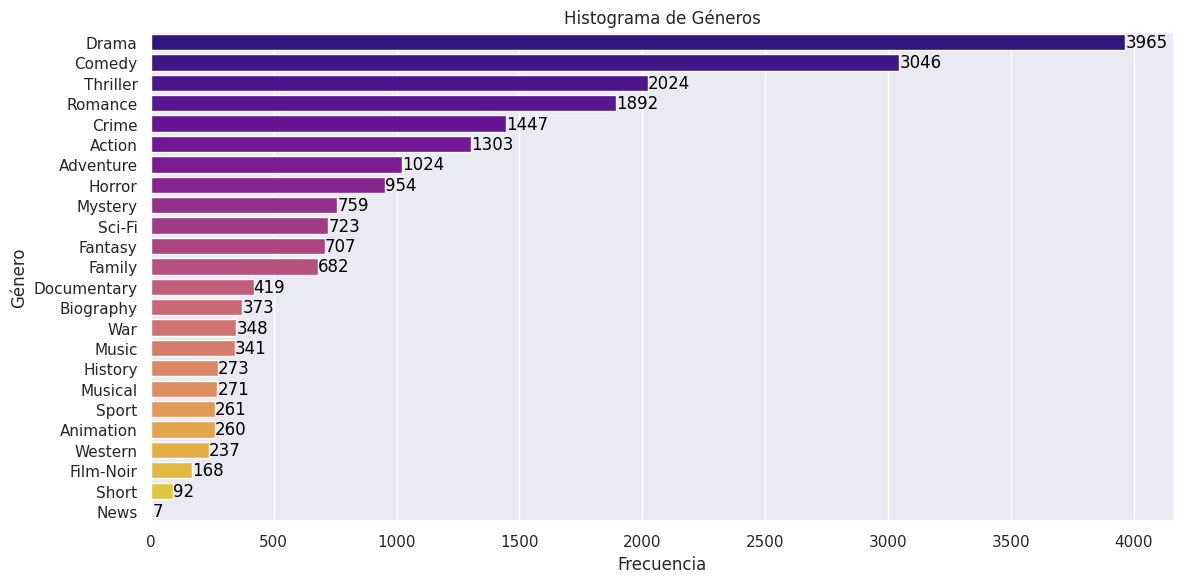

In [14]:
genre_counts = df_y_genres.sum(axis=0)

plt.figure(figsize=(12, 6))
sorted_genres = genre_counts.sort_values(ascending=False)
sorted_classes = sorted_genres.index

ax = sns.barplot(x=sorted_genres.values, y=sorted_classes, palette='plasma')
plt.title('Histograma de Géneros')
plt.xlabel('Frecuencia')
plt.ylabel('Género')

# Añadir etiquetas de datos en las barras
for i, count in enumerate(sorted_genres.values):
    y_pos = min(count + 10, max(sorted_genres.values) + 20)
    ax.text(count, i, str(count), ha='left', va='center', color='black')

plt.tight_layout()
plt.show()

### Análisis multivariado de '*genres*' (multiclase)

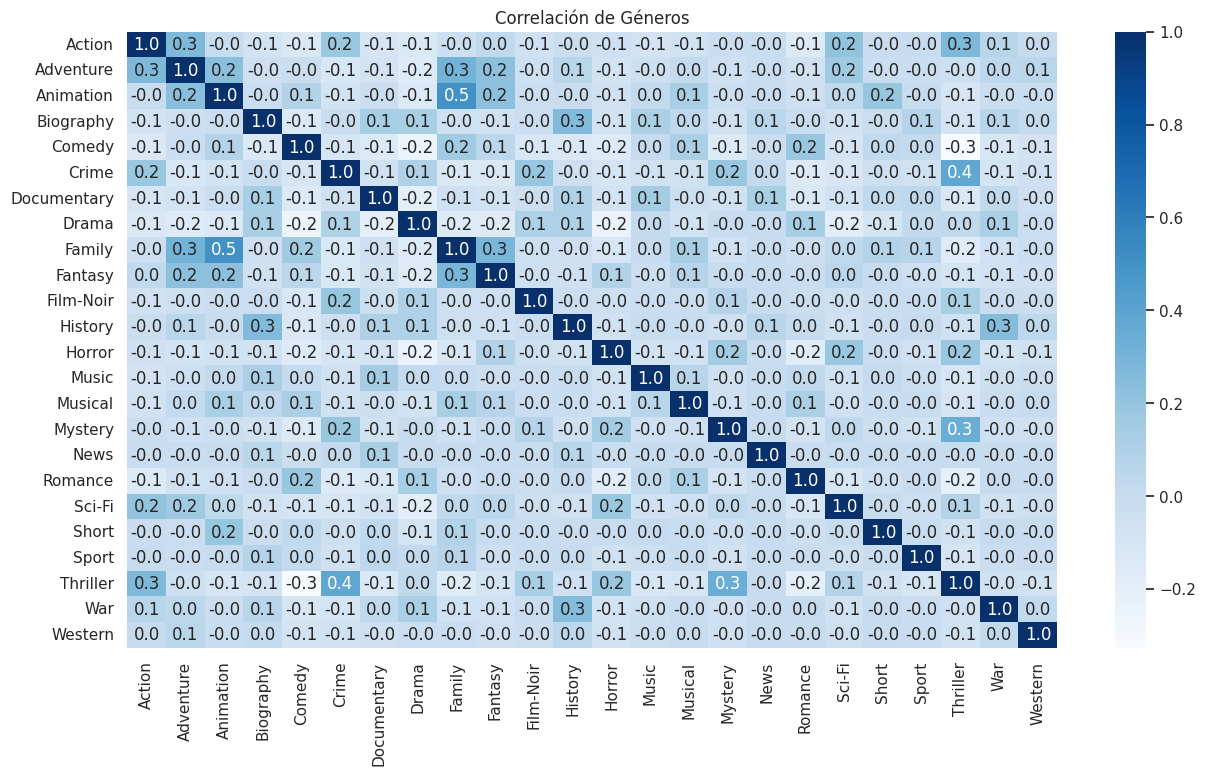

In [15]:
correlation_matrix = df_y_genres.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".1f")
plt.title('Correlación de Géneros')
plt.show()

Mayor correlación positiva entre '*Family*' y '*Animation*' = 0.5

Mayor correlación negativa entre '*Triller*' y '*Comedy*' = -0.3

# **2. Limpieza de texto**

In [16]:
# Verificar si hay valores nulos

variables=['year', 'title', 'plot','genres', 'rating']

valores_faltantes = dataTraining[variables].apply(lambda col: col.isnull().sum())

df_valores_faltantes = pd.DataFrame({
    'Variable': valores_faltantes.index,
    'Total_Faltantes': valores_faltantes.values
})

df_valores_faltantes


,Variable,Total_Faltantes
0,year,0
1,title,0
2,plot,0
3,genres,0
4,rating,0


In [17]:
# Verificar si hay valores nulos

variables=['plot']

valores_faltantes = dataTesting[variables].apply(lambda col: col.isnull().sum())

df_valores_faltantes = pd.DataFrame({
    'Variable': valores_faltantes.index,
    'Total_Faltantes': valores_faltantes.values
})

df_valores_faltantes

,Variable,Total_Faltantes
0,plot,0


# **3. Preprocesamiento de texto**

In [37]:
nltk.download('stopwords') # Descargar la lista de palabras comunes (stopwords) en varios idiomas que se consideran poco informativas en el análisis de texto.
nltk.download('punkt') # Descarga los modelos y datos necesarios para la tokenización del texto.

# Función para quitar stopwords
def quitar_stopwords(plot):
    plot_tokenizado = word_tokenize(plot)  # Tokenizar el texto
    stop_words = set(stopwords.words('english')) # Cargar stopwords en inglés
    return [palabra for palabra in plot_tokenizado if palabra not in stop_words]

# Función para aplicar stemming
#def stemming(plot):
    #stemmer = SnowballStemmer('english')
    #plot_stemming = [stemmer.stem(palabra) for palabra in plot]
    #return plot_stemming

# Función para procesar el plot
def procesamiento(plot):
    plot = plot.lower() # Convertir texto a minúsculas
    plot = re.sub(r'[^a-zA-Z0-9]', ' ', plot) # Remover caracteres que no sean letras ni números
    plot = re.sub(r'[^\w\s]', '', plot) # Remover signos de puntuación y reemplazar por un espacio, antes de tokenizar
    plot_sinStopwords = quitar_stopwords(plot)  # Remover stop words
    #plot_conStemming = stemming(plot_sinStopwords) # Stemming de las palabras
    plot_limpio = ' '.join(plot_sinStopwords) # Unir los tokens nuevamente en texto
    return plot_limpio



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
# Definir X_train en un dataframe con el texto limpio o procesado
df_x_limpio_train = df_x_plot_train[['plot']].copy()
df_x_limpio_train['plot_limpio'] = df_x_plot_train['plot'].apply(procesamiento)

df_x_limpio_train.head()

,plot,plot_limpio
0,most is the story of a single father who takes...,story single father takes eight year old son w...
1,a serial killer decides to teach the secrets o...,serial killer decides teach secrets satisfying...
2,"in sweden , a female blackmailer with a disfi...",sweden female blackmailer disfiguring facial s...
3,"in a friday afternoon in new york , the presi...",friday afternoon new york president tredway co...
4,"in los angeles , the editor of a publishing h...",los angeles editor publishing house carol hunn...


In [39]:
# Definir X_test en un dataframe con el texto limpio o procesado
df_x_limpio_test = df_x_plot_test[['plot']].copy()
df_x_limpio_test['plot_limpio'] = df_x_plot_test['plot'].apply(procesamiento)

df_x_limpio_test.head()

,plot,plot_limpio
0,"who meets by fate , shall be sealed by fate ....",meets fate shall sealed fate theresa osborne r...
1,"the true story of billy hayes , an american c...",true story billy hayes american college studen...
2,martin vail left the chicago da ' s office to ...,martin vail left chicago da office become succ...
3,husband and wife americans dr . eugene and mr...,husband wife americans dr eugene mrs helen fer...
4,the coroner and scientist dr . warren chapin ...,coroner scientist dr warren chapin researching...


# **4. Feature Engineering**

## Word Embeddings

In [40]:
import tensorflow as tf
import tensorflow_hub as hub

In [41]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
use_embed = hub.load(module_url)

In [42]:
train_embe_plot = use_embed(df_x_limpio_train['plot'])
test_embe_plot = use_embed(df_x_limpio_test['plot'])

In [43]:
train_embe_limpio = use_embed(df_x_limpio_train['plot_limpio'])
test_embe_limpio = use_embed(df_x_limpio_test['plot_limpio'])

# **5. Modelado**

In [44]:
train_embe_limpio_np = train_embe_limpio.numpy()
X_train, X_test, y_train, y_test = train_test_split(train_embe_limpio_np, df_y_genres, test_size=0.33, random_state=42)

## Random Forest Classifier

In [45]:
modelo_rf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=20, min_samples_split=2, min_samples_leaf=4, max_leaf_nodes=20, random_state=42))
modelo_rf.fit(X_train, y_train)
y_pred_genres = modelo_rf.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

0.8533061635480403

In [ ]:
# NO EJECUTAR

# Predecir las probabilidades en el conjunto de entrenamiento
y_train_pred_genres = modelo_rf.predict_proba(X_train)

# Calcular el AUC en el conjunto de entrenamiento
auc_modelo_rf_train = roc_auc_score(y_train, y_train_pred_genres, average='macro', multi_class='ovr') #One-vs-Rest (OvR)

# Predecir las probabilidades en el conjunto de prueba
y_test_pred_genres = modelo_rf.predict_proba(X_test)

# Calcular el AUC en el conjunto de prueba
auc_modelo_rf_test = roc_auc_score(y_test, y_test_pred_genres, average='macro', multi_class='ovr') #One-vs-Rest (OvR)

# Mostrar los resultados
print(f"AUC en el conjunto de entrenamiento: {auc_modelo_rf_train}")
print(f"AUC en el conjunto de prueba: {auc_modelo_rf_test}")

# Evaluar si hay sobreajuste
if auc_modelo_rf_train - auc_modelo_rf_test > 0.05:  # Umbral de sobreajuste
    print("Posible sobreajuste detectado. El modelo se ajusta mejor al conjunto de entrenamiento que al de prueba.")
else:
    print("No se detecta sobreajuste significativo.")

In [ ]:
# NO EJECUTAR

# Crear un DataFrame vacío para almacenar los resultados
df_resultados = pd.DataFrame(columns=['Modelo','AUC_Test', 'AUC_Train'])

# Agregar el resultado al DataFrame de resultados
nombre_modelo_1 = 'Random Forest Classifier'
df_resultados = df_resultados.append({'Modelo': nombre_modelo_1,'AUC_Test': auc_modelo_rf_test, 'AUC_Train': auc_modelo_rf_train}, ignore_index=True)

## XGBoost OneVsRestClassifier

Si el modelo Random Forest tiene un rendimiento muy bajo.
Bagging se recomienda si hay overfitting en el modelo Ramdom Forest.

In [46]:
from xgboost import XGBClassifier
modelo_XG = OneVsRestClassifier(XGBClassifier(n_jobs=-1, n_estimators=300, max_depth=20, min_samples_split=2, min_samples_leaf=4, max_leaf_nodes=20,random_state=42))
modelo_XG.fit(X_train, y_train)
y_pred_genres = modelo_XG.predict_proba(X_test)
roc_auc_score(y_test, y_pred_genres, average='macro')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:26:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:27:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:27:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:28:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


0.8765483615480708

In [ ]:
# NO EJECUTAR

# Predecir las probabilidades en el conjunto de entrenamiento
y_train_pred_sentiment = modelo_XG_GS.predict_proba(X_train)

# Calcular el AUC en el conjunto de entrenamiento
auc_modelo1_rf_train = roc_auc_score(y_train, y_train_pred_sentiment, average='macro', multi_class='ovr') #One-vs-Rest (OvR)

# Predecir las probabilidades en el conjunto de prueba
y_test_pred_sentiment = modelo_XG_GS.predict_proba(X_test)

# Calcular el AUC en el conjunto de prueba
auc_modelo1_rf_test = roc_auc_score(y_test, y_test_pred_sentiment, average='macro', multi_class='ovr') #One-vs-Rest (OvR)

# Mostrar los resultados
print(f"AUC en el conjunto de entrenamiento: {auc_modelo1_rf_train}")
print(f"AUC en el conjunto de prueba: {auc_modelo1_rf_test}")

# Evaluar si hay sobreajuste
if auc_modelo1_rf_train - auc_modelo1_rf_test > 0.05:  # Umbral de sobreajuste
    print("Posible sobreajuste detectado. El modelo se ajusta mejor al conjunto de entrenamiento que al de prueba.")
else:
    print("No se detecta sobreajuste significativo.")

In [ ]:
# NO EJECUTAR

# Agregar el resultado al DataFrame de resultados
nombre_modelo_1 = 'Random Forest Classifier'
df_resultados = df_resultados.append({'Modelo': nombre_modelo_1,'AUC_Test': auc_modelo_rf_test, 'AUC_Train': auc_modelo_rf_train}, ignore_index=True)

In [ ]:
# NO EJECUTAR, corre por más de 24 horas y no finaliza, ni con GPUs L4

#Entrenar un modelo con XGBoost multi-class
modelo_XG = OneVsRestClassifier(XGBClassifier(random_state=42))

# Definir la cuadrícula de hiperparámetros
param_grid = {
            'estimator__n_estimators': [100, 200, 300],
            'estimator__max_depth': [2, 10, 20],
            'estimator__min_samples_split': [2, 5, 10],
            'estimator__min_samples_leaf': [1, 2, 4],
            'estimator__max_leaf_nodes': [4, 10, 20],
            'estimator__random_state': [42]
}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(modelo_XG, param_grid, cv=5, scoring='roc_auc_ovr')
grid_search.fit(X_train, y_train)


# Obtener el mejor modelo
modelo_XG_GS = grid_search.best_estimator_

print(grid_search.best_params_)
print(grid_search.best_estimator_)

# Entrenar el mejor modelo
modelo_XG_GS.fit(X_train, y_train)

Se han truncado las últimas 5000 líneas del flujo de salida.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:48:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:48:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:48:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:48:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nod

## Red neuronal

Revisar con redes preentrenadas - NO EJECUTAR

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

# Limpiar la sesión de TensorFlow
tf.keras.backend.clear_session()

In [ ]:
# Definir el número de clases
num_classes = y_train.shape[1]
num_classes

In [ ]:
# Crear el modelo de red neuronal
model = Sequential()

# Agregar capas al modelo
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Usar 'softmax' para problemas de clasificación multiclase

# Compilar el modelo
metric = [metrics.AUC(from_logits=True, multi_label=True)]
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metric)

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predecir las probabilidades de las clases en el conjunto de prueba
y_pred_prob = model.predict(X_test)
# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_prob, average='macro')
print(f'AUC: {auc}')

# **6. Evaluación**

In [ ]:
# Mostrar el DataFrame con los resultados del AUC por Modelo
df_resultados = df_resultados.sort_values(by='AUC_Test', ascending=False)
df_resultados